In [1]:
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
import plotly.express as px
import numpy as np
from wordcloud import WordCloud

In [2]:
warnings.filterwarnings("ignore")

First, let's extract some Pokemon data from PokeAPI. The analysis will concern all 1015 Pokemon species created so far (Oct. 2023).

In [3]:
list_url = "https://pokeapi.co/api/v2/pokemon?limit=1015&offset=0"
data = requests.get(list_url).json()

print(len(data["results"]))

1015


Doing a little bit of JSON parsing...

In [4]:
poke_url = data['results'][0]['url']

poke_data = requests.get(poke_url).json()

stats = poke_data['stats']

We can finally have a DataFrame with Pokemon information.

In [5]:
info = [['name', 'type', 'hp', 'attack', 'defense',
        'special-attack', 'special-defense',
        'speed']]

for poke_url in data['results']:

  poke_data = requests.get(poke_url['url']).json()
  stats = poke_data['stats']

  poke_list = [poke_data['name'], poke_data['types'][0]['type']['name']]

  for stat in stats:
    poke_list.append(stat['base_stat'])

  info.append(poke_list)

df = pd.DataFrame(info)

df.columns = df.iloc[0]
df = df[1:]

df.head(4)

,name,type,hp,attack,defense,special-attack,special-defense,speed
1,bulbasaur,grass,45,49,49,65,65,45
2,ivysaur,grass,60,62,63,80,80,60
3,venusaur,grass,80,82,83,100,100,80
4,charmander,fire,39,52,43,60,50,65


We will investigate Pokemon type patterns. Maybe some types are closer to each other in their stats. As a first step, maybe grouping the types and checking their mean stats should tell us something.

In [6]:
df_group = df.loc[:, df.columns != 'name'].groupby('type').agg('mean')

df_group

,hp,attack,defense,special-attack,special-defense,speed
type,,,,,,
bug,56.493976,67.554217,69.578313,56.433735,63.313253,61.265060
dark,75.800000,88.000000,71.622222,72.933333,70.755556,75.622222
dragon,79.594595,98.972973,75.216216,78.486486,77.702703,80.189189
electric,63.741379,72.965517,61.603448,83.931034,66.172414,85.241379
fairy,71.379310,66.827586,70.965517,76.103448,85.793103,65.000000
fighting,76.075000,102.700000,72.350000,53.175000,67.275000,69.975000
fire,69.292308,82.107692,66.000000,83.553846,69.184615,73.846154
flying,70.000000,79.888889,66.000000,68.444444,68.777778,83.000000
ghost,61.800000,68.600000,75.485714,84.114286,80.828571,60.342857


As there are many stats, it doesn't seem to be that conclusive, at least so far. Maybe reducing the number of features can help us extract good inferences from the data. Let's try to use some principal component analysis (PCA) to do that. We will establish a threshold of 95% for the cumulative explained variance (i.e., 95% of the variance in the dataset can be explained by the principal components).

In [7]:
original_df = df.copy()

df = df.loc[:, (df.columns != 'name') & (df.columns != 'type')]

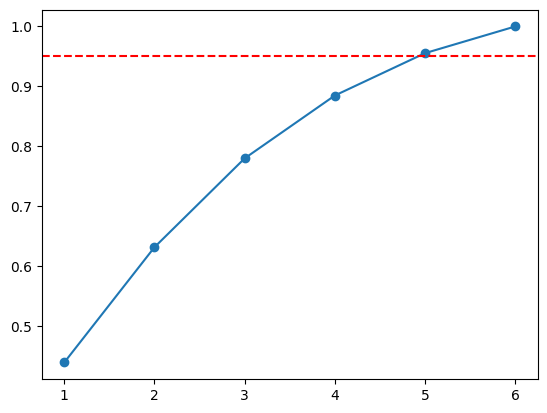

In [8]:
components = []

cum_sum = []

for n in range(1,7):
  pca = PCA(n_components=n)

  pca.fit_transform(df)

  prop_var = pca.explained_variance_ratio_

  components.append(n)

  cum_sum.append(prop_var.sum())

plt.plot(components, cum_sum, marker='o')
plt.axhline(0.95, linestyle='--', color='r')
plt.show()

We see that choosing 5 principal components falls slightly above our threshold of 95%. Considering that we had 6 features originally, though, PCA doesn't offer such a great improvement. Another possibility is checking the correlation factors between features.

[]

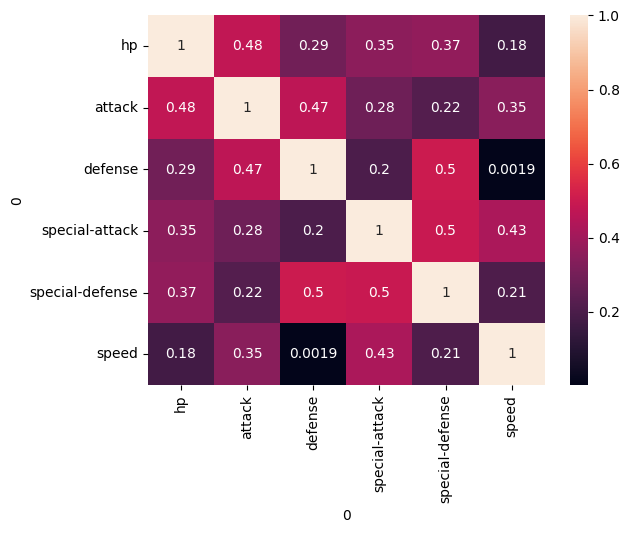

In [9]:
df = df.astype(float)

matrix = df.corr()

sns.heatmap(matrix, annot=True)
plt.plot()

None of the correlation factors seem particularly relevant. It seems that it's proper to use all six features, indeed. Now, it's time to choose the number of clusters. We use the elbow method for that.

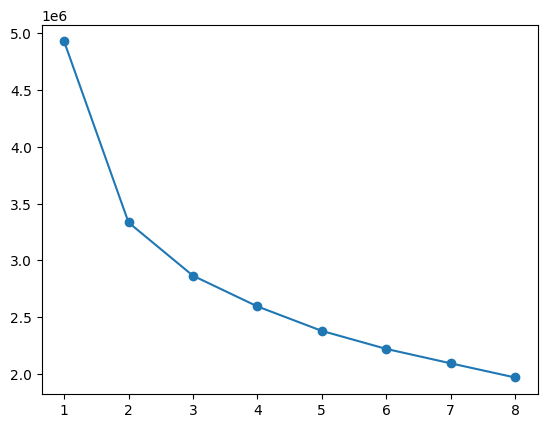

In [10]:
wcss = []

for i in range(1, 9):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 9), wcss, marker='o')
plt.show()

We don't see a very clear elbow, but let's choose n=3, as it still seems to be the best option. So, we are going to use a KMeans algorithm with n_clusters=3.

In [11]:
kmeans = KMeans(n_clusters=3)

kmeans.fit(df)
y_kmeans = kmeans.predict(df)

Let's merge our new clustered dataframe with the original one so we can identify the Pokemon and their types based on the new labels.

In [12]:
df_final = df.copy()

df_final['label'] = y_kmeans

df_final = pd.merge(original_df[['name', 'type']], df_final, left_index=True,
                    right_index=True)

df_final.head(4)

,name,type,hp,attack,defense,special-attack,special-defense,speed,label
1,bulbasaur,grass,45.0,49.0,49.0,65.0,65.0,45.0,2
2,ivysaur,grass,60.0,62.0,63.0,80.0,80.0,60.0,2
3,venusaur,grass,80.0,82.0,83.0,100.0,100.0,80.0,0
4,charmander,fire,39.0,52.0,43.0,60.0,50.0,65.0,2


Now it's time to visualize things! Radar charts should be an interesting choice. Let's make a function to plot them easily.

In [13]:
def plot_radar_chart(grouped_df, title):

  value = list(grouped_df.to_numpy().flatten())

  group = list(np.concatenate([[label]*len(grouped_df.columns)
  for label in grouped_df.index]))

  variable = list(grouped_df.columns)*len(grouped_df.index)

  # Sample data
  df = pd.DataFrame(dict(
      value = value,
      variable = variable,
      group = group))

  fig = px.line_polar(df, r = 'value', theta = 'variable', line_close = True,
                      color = 'group')

  fig.update_layout(
      autosize=False,
      width=500,
      height=500,
      title={
          'text': title,
          'y':1.0,
          'x':0.495,
          'xanchor': 'center',
          'yanchor': 'top'})
  fig.update_traces(fill = 'toself')

  fig.show('png')

  return

And we then plot radar charts for each cluster based on stats means and medians.

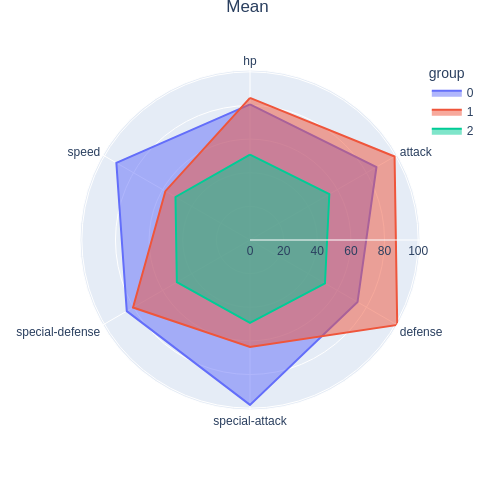

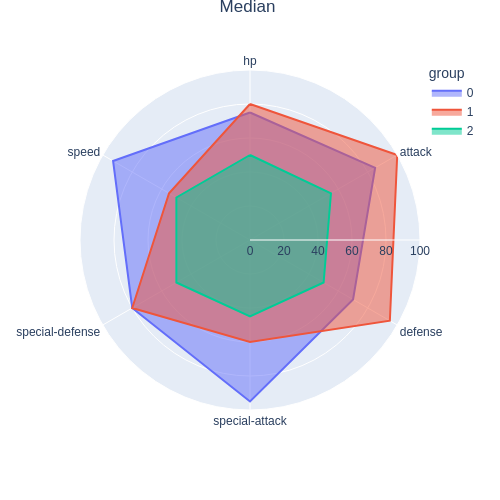

In [14]:
mean_df = df_final.groupby('label').mean()

median_df = df_final.groupby('label').median()

plot_radar_chart(mean_df, 'Mean')

plot_radar_chart(median_df, 'Median')

We see some clear patterns. It seems that there's a group of generally weaker, but very stats-balanced Pokemon (**group 2**). **Groups 0 and 1** are stronger in general than group 0, but **group 1** focuses on attack and defense, while **group 0** focuses on speed and special attack. Now, let's check if there are dominant types in each group. Let's make first a word cloud for types using all the dataset.

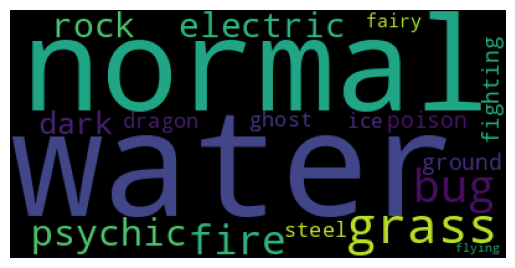

In [15]:
my_list = df_final['type']
unique_string = (", ").join(my_list)
wordcloud = WordCloud(collocations=False).generate(unique_string)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

We see that Water and Normal are the dominant types for all the Pokemon. But how are the clustered groups?

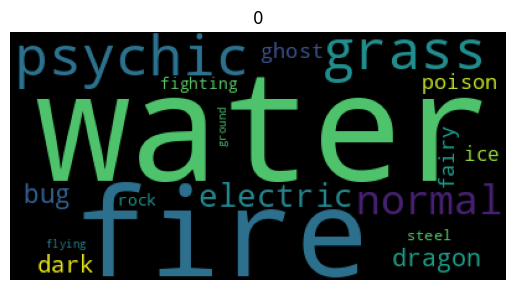

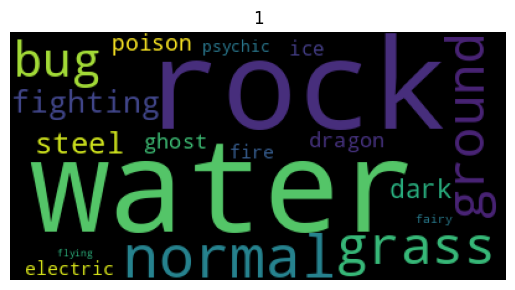

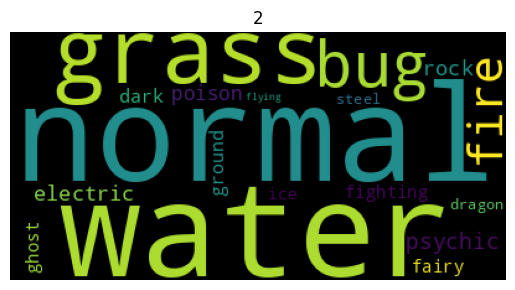

In [16]:
for label in np.sort(df_final['label'].unique()):
  my_list = df_final[df_final['label'] == label]['type']
  unique_string = (" ").join(my_list)
  wordcloud = WordCloud(collocations=False).generate(unique_string)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title(label)
  plt.show()

Just by looking at the clouds, we can make some inferences. Fire is very present in group 0's wordcloud and not in the others. We can then associate the Fire type with general higher speed and special attack. The same thing happens with the Rock type and group 1: we can associate it with higher attack and defense. Group 2 looks relatively similar to the general distribution, even though some types are more frequent here than before, such as Bug and Grass. That could mean that group 2 behaves a bit like a general representation of weaker Pokemon.